# Step 1: Import **Libraries**

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn nltk xgboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import string


# *🗂 Step 2: Load the Dataset*

In [13]:
df = pd.read_csv('/content/rows.csv', low_memory=False, on_bad_lines='skip')
print("Shape of data:", df.shape)
print("\nColumns:\n", df.columns)
df.head()

Shape of data: (152986, 18)

Columns:
 Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275.0
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228.0
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,NaN,NaN,CURO Intermediate Holdings,TX,751XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3237964.0
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,Ad Astra Recovery Services Inc,LA,708XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3238479.0
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,ALLY FINANCIAL INC.,AZ,85205,NaN,NaN,Postal mail,05/10/2019,In progress,Yes,NaN,3238460.0


# **🔍 Step 3: Exploratory Data Analysis (EDA)**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152986 entries, 0 to 152985
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date received                 152986 non-null  object 
 1   Product                       152986 non-null  object 
 2   Sub-product                   152986 non-null  object 
 3   Issue                         152986 non-null  object 
 4   Sub-issue                     132867 non-null  object 
 5   Consumer complaint narrative  48226 non-null   object 
 6   Company public response       75108 non-null   object 
 7   Company                       152986 non-null  object 
 8   State                         147989 non-null  object 
 9   ZIP code                      131144 non-null  object 
 10  Tags                          20631 non-null   object 
 11  Consumer consent provided?    98026 non-null   object 
 12  Submitted via                 152985 non-nul

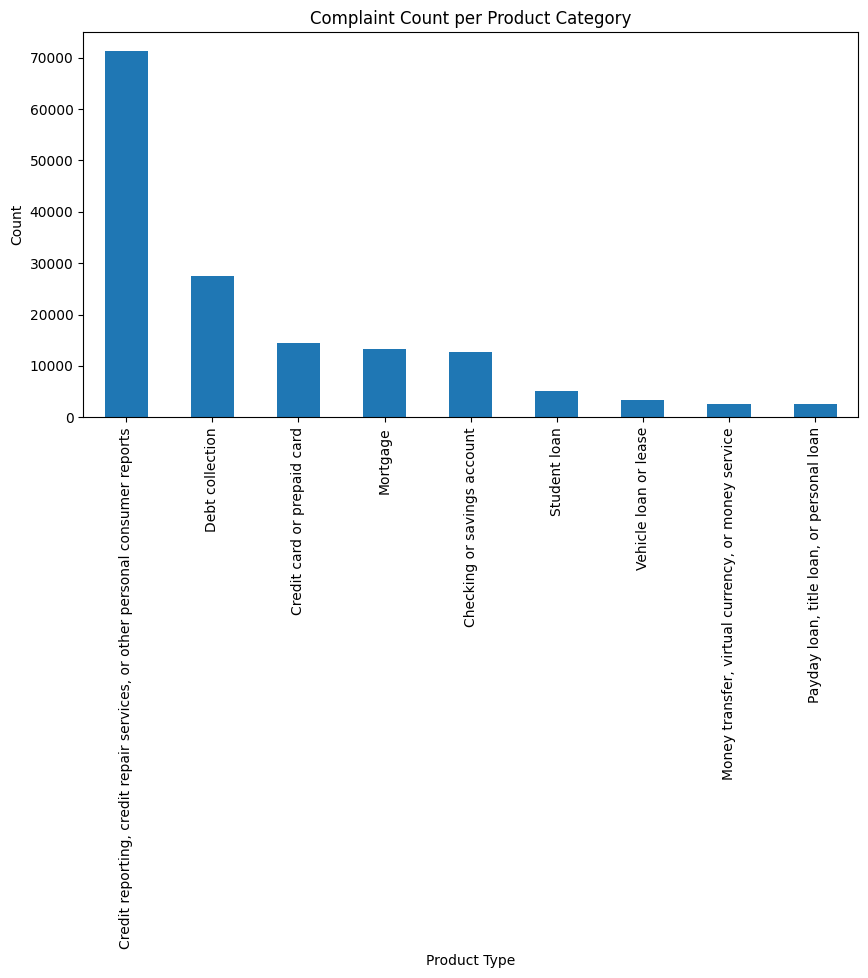

In [14]:
# Step 3: EDA
print(df.info())
print(df.isnull().sum())

# Let's look at the distribution of 'Product' (target category)
plt.figure(figsize=(10,5))
df['Product'].value_counts().plot(kind='bar')
plt.title('Complaint Count per Product Category')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.show()


# **Step 4: Filter Only 4 Categories**

In [15]:
target_categories = [
    'Credit reporting, repair, or other',
    'Debt collection',
    'Consumer Loan',
    'Mortgage'
]

df = df[df['Product'].isin(target_categories)].copy()

print("Filtered dataset shape:", df.shape)
print(df['Product'].value_counts())


Filtered dataset shape: (40787, 18)
Product
Debt collection    27467
Mortgage           13320
Name: count, dtype: int64


In [31]:
df['Product'].unique()


array(['Debt collection', 'Mortgage'], dtype=object)

In [16]:
label_map = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

df['label'] = df['Product'].map(label_map)


# **✍️ Step 5: Feature Engineering**

In [17]:
# Drop missing texts
df = df.dropna(subset=['Consumer complaint narrative'])

X = df['Consumer complaint narrative']
y = df['label']


# **🧹 Step 6: Text Preprocessing**

In [25]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import re
import string

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text) # Ensure the input is a string
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Fill missing values with empty string before cleaning
X = X.fillna('').apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (13864, 5000)


# **Step 7 : Model Selection**

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, random_state=42, stratify=y)


In [42]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.9719
              precision    recall  f1-score   support

           1       0.98      0.98      0.98      1977
           3       0.95      0.95      0.95       796

    accuracy                           0.97      2773
   macro avg       0.97      0.96      0.97      2773
weighted avg       0.97      0.97      0.97      2773


Naive Bayes Accuracy: 0.9708
              precision    recall  f1-score   support

           1       0.98      0.98      0.98      1977
           3       0.94      0.96      0.95       796

    accuracy                           0.97      2773
   macro avg       0.96      0.97      0.96      2773
weighted avg       0.97      0.97      0.97      2773


Random Forest Accuracy: 0.9758
              precision    recall  f1-score   support

           1       0.98      0.99      0.98      1977
           3       0.96      0.95      0.96       796

    accuracy                           0.98      2773
   macro avg       0.97     

# **Step 8:Compare Model Performance**

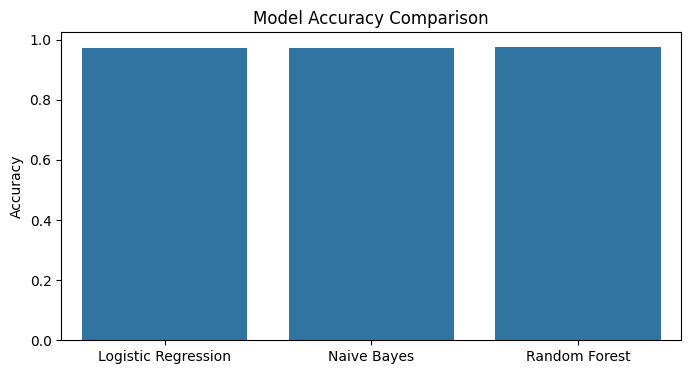

In [43]:
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


# **Step 9: Model Evaluation**

In [45]:
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1941   36]
 [  42  754]]

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.98      0.98      1977
           3       0.95      0.95      0.95       796

    accuracy                           0.97      2773
   macro avg       0.97      0.96      0.97      2773
weighted avg       0.97      0.97      0.97      2773



# **step 10: Prediction on New Complaint**

In [46]:
def predict_category(text):
    cleaned = clean_text(text)
    vect = vectorizer.transform([cleaned])
    pred = best_model.predict(vect)[0]
    for key, value in label_map.items():
        if value == pred:
            return key

# Example
sample_text = "My mortgage payment was incorrectly reported to the credit bureau."
print("Predicted Category:", predict_category(sample_text))


Predicted Category: Mortgage
